# Modeling and Simulation in Python

Case Study: Queueing theory

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## One queue or two?

This notebook presents a solution to an exercise from *Modeling and Simulation in Python*.  It uses features from the first four chapters to answer a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  Since it's a new store, we don't know what the value of $\lambda$ will be, so we'll have to consider a range of possibilities.  

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

### One server, one queue

I'll start by defining a `System` object to contain the system parameters.

In [2]:
def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=8*60)

As an example, I'll set the arrival rate to one customer per 8 minutes.

In [3]:
interarrival_time = 8
service_time = 5

lam = 1 / interarrival_time
mu = 1 / service_time

system = make_system(lam, mu)

,values
lam,0.125
mu,0.200
duration,480.000


Here's a update function that simulates a single time step.  During each time step, a customer can finish checking out (but only if there is a customer in the system), and a new customer can arrive.

In [4]:
def update_func1(x, t, system):
    """Simulate one time step.
    
    x: number of people in the shop
    t: time step
    system: System object
    """
    # if there's a customer in service, check if they're done
    if x > 0:
        if flip(system.mu):
            x -= 1
            
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x

Now we can run the simulation.  `run_simulation` creates a `TimeSeries` that maps from each time step to the total number of customers in the store, including the one checking out.

After the simulation, we compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.

In [5]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration-1):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

def compute_metrics(results, system):
    """
    """
    L = results.mean()
    W = L / system.lam
    return L, W

Here are the results with the parameters we chose.

(0.8835758835758836, 7.0686070686070686)

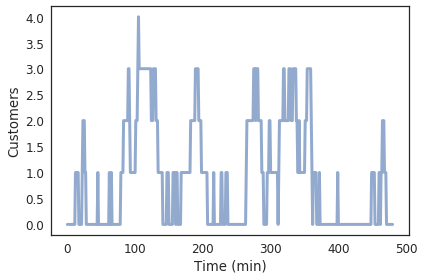

In [6]:
results = run_simulation(system, update_func1)
plot(results)
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate.

If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.

In [7]:
mu = 1 / service_time
num_vals = 101
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
print(mu)
lam_array

0.2


array([0.02  , 0.0214, 0.0228, 0.0242, 0.0256, 0.027 , 0.0284, 0.0298,
       0.0312, 0.0326, 0.034 , 0.0354, 0.0368, 0.0382, 0.0396, 0.041 ,
       0.0424, 0.0438, 0.0452, 0.0466, 0.048 , 0.0494, 0.0508, 0.0522,
       0.0536, 0.055 , 0.0564, 0.0578, 0.0592, 0.0606, 0.062 , 0.0634,
       0.0648, 0.0662, 0.0676, 0.069 , 0.0704, 0.0718, 0.0732, 0.0746,
       0.076 , 0.0774, 0.0788, 0.0802, 0.0816, 0.083 , 0.0844, 0.0858,
       0.0872, 0.0886, 0.09  , 0.0914, 0.0928, 0.0942, 0.0956, 0.097 ,
       0.0984, 0.0998, 0.1012, 0.1026, 0.104 , 0.1054, 0.1068, 0.1082,
       0.1096, 0.111 , 0.1124, 0.1138, 0.1152, 0.1166, 0.118 , 0.1194,
       0.1208, 0.1222, 0.1236, 0.125 , 0.1264, 0.1278, 0.1292, 0.1306,
       0.132 , 0.1334, 0.1348, 0.1362, 0.1376, 0.139 , 0.1404, 0.1418,
       0.1432, 0.1446, 0.146 , 0.1474, 0.1488, 0.1502, 0.1516, 0.153 ,
       0.1544, 0.1558, 0.1572, 0.1586, 0.16  ])

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.  In particular, we expect the average time in the store to be:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

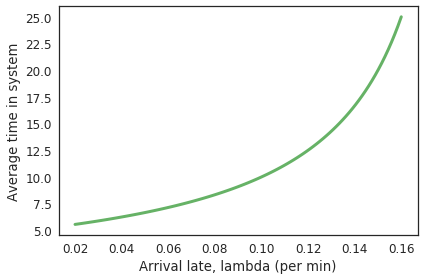

In [8]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')
    
plot_W(lam_array, mu)
decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system')

### Parameter sweep

Now let's run the simulation with a range of values for $\lambda$ and plot the observed value of `W` versus `lam`:

In [9]:
def sweep_lam(lam_array, mu, update_func):
    """Run simulations with a range of values for `lam`
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    update_func: passed along to run_simulation
    
    returns: SweepSeries of average wait time vs lam
    """
    sweep = SweepSeries()
    
    for lam in lam_array:
        system = make_system(lam, mu)
        results = run_simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W
        
    return sweep

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

Here are the results for a single queue with a single checkout counter.

Average of averages =  8.865740344299903 minutes


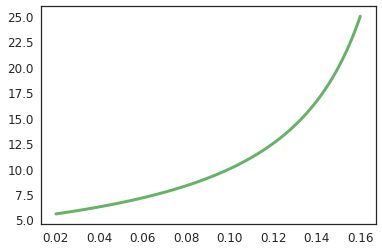

In [10]:
plot_W(lam_array, mu)

sweep = sweep_lam(lam_array, mu, update_func1)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

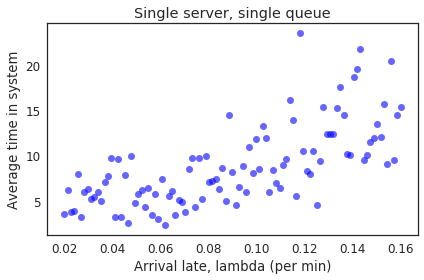

In [11]:
plot(sweep, 'bo')

decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

The results on any simulated day are highly variable, but looks like the theoretical result is plausible.  The simulated results tend to be lower, maybe because they include a cold start at the beginning of each day.

## Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](figs/queue.png)

Here's the update function for one queue with two servers.

In [12]:
def update_func2(x, t, system):
    """Simulate a single queue with two servers.
    
    system: System object
    """
    # if both servers are busy, check whether the
    # second is complete
    if x > 1 and flip(system.mu):
        x -= 1
            
    # check whether the first is complete
    if x > 0 and flip(system.mu):
        x -= 1
    
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x

Here are the results for a single run.

(0.8835758835758836, 7.0686070686070686)

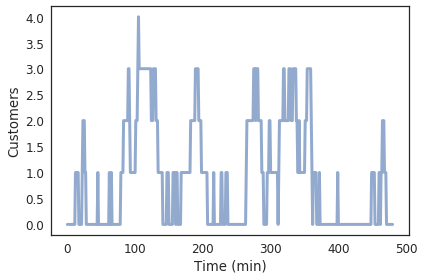

In [13]:
system = make_system(lam, mu)
run_simulation(system, update_func2)
plot(results)
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

Since we have two counters now, we can consider a wider range of values for $\lambda$

In [14]:
lam_array = linspace(0.1*mu, 1.6*mu, num_vals)

array([0.02 , 0.023, 0.026, 0.029, 0.032, 0.035, 0.038, 0.041, 0.044,
       0.047, 0.05 , 0.053, 0.056, 0.059, 0.062, 0.065, 0.068, 0.071,
       0.074, 0.077, 0.08 , 0.083, 0.086, 0.089, 0.092, 0.095, 0.098,
       0.101, 0.104, 0.107, 0.11 , 0.113, 0.116, 0.119, 0.122, 0.125,
       0.128, 0.131, 0.134, 0.137, 0.14 , 0.143, 0.146, 0.149, 0.152,
       0.155, 0.158, 0.161, 0.164, 0.167, 0.17 , 0.173, 0.176, 0.179,
       0.182, 0.185, 0.188, 0.191, 0.194, 0.197, 0.2  , 0.203, 0.206,
       0.209, 0.212, 0.215, 0.218, 0.221, 0.224, 0.227, 0.23 , 0.233,
       0.236, 0.239, 0.242, 0.245, 0.248, 0.251, 0.254, 0.257, 0.26 ,
       0.263, 0.266, 0.269, 0.272, 0.275, 0.278, 0.281, 0.284, 0.287,
       0.29 , 0.293, 0.296, 0.299, 0.302, 0.305, 0.308, 0.311, 0.314,
       0.317, 0.32 ])

Here's what the results look like.  With two counters, the average time in the store is lower, even for higher values of $\lambda$

In [15]:
sweep = sweep_lam(lam_array, mu, update_func2)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  5.91700939168766 minutes


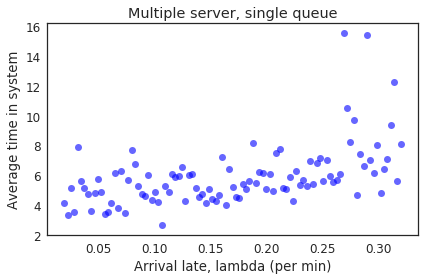

In [16]:
plot(sweep, 'bo')
decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

### Multiple queues

Finally, here's the update function for the scenario with two separate queues.

In [17]:
def update_func3(x1, x2, t, system):
    """Simulate two queues with one server each.
    
    x1: number of customers in queue 1
    x2: number of customers in queue 2
    t: time step
    system: System object
    """
    # if the first servers is busy, check it it's done
    if x1 > 0 and flip(system.mu):
        x1 -= 1
            
    # if the second queue is busy, check if it's done
    if x2 > 0 and flip(system.mu):
        x2 -= 1
            
    # check for an arrival
    if flip(system.lam):
        # join whichever queue is shorter
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1
            
    return x1, x2

This update function takes and returns two  variables, `x1` and `x2`, so we need a new version of `run_simulation`:

In [18]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2
    
    for t in linrange(0, system.duration-1):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2

    return results

Here are the results for a single run

(0.8835758835758836, 7.0686070686070686)

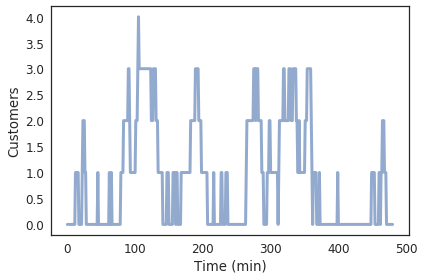

In [19]:
system = make_system(lam, mu)
run_simulation(system, update_func3)
plot(results)
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

And here are the results for a range of values of `lam`

In [20]:
sweep = sweep_lam(lam_array, mu, update_func3)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.500924010363111 minutes


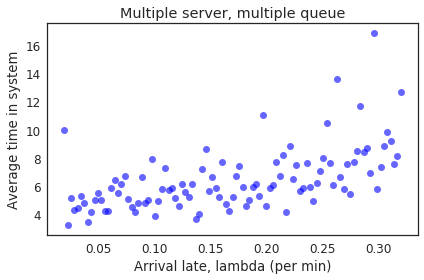

In [21]:
plot(sweep, 'bo')
decorate(xlabel='Arrival late, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, multiple queue')

With two queues, the average of averages is slightly higher, most of the time.  But the difference is small.

The two configurations are equally good as long as both servers are busy; the only time two lines is worse is if one queue is empty and the other contains more than one customer.  In real life, if we allow customers to change lanes, that disadvantage can be eliminated.

From a theoretical point of view, one line is better.  From a practical point of view, the difference is small and can be mitigated.  So the best choice depends on practical considerations.

On the other hand, you can do substantially better with an express line for customers with short service times.  But that's a topic for another notebook.